In [41]:
# Load csv
import pandas as pd

# Scaling the data
from sklearn.preprocessing import StandardScaler

# Import KMeans clustering algorithm
from sklearn.cluster import KMeans

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [42]:

# ----------------------------------------------------
# Step 1: Load dataset and keep only relevant columns
# ----------------------------------------------------
df = pd.read_csv("fifa.csv")

# Keep only the columns that matter
df = df[['Name', 'Overall', 'Potential', 'Value', 'Wage']].dropna()

In [43]:
# ----------------------------------------------------
# Step 2: Convert currency strings into numeric values
# ----------------------------------------------------
def convert_currency(x):
    x = x.replace('€', '')
    if 'M' in x:
        return float(x.replace('M', '')) * 1_000_000
    if 'K' in x:
        return float(x.replace('K', '')) * 1_000
    return float(x)
df['Value'] = df['Value'].apply(convert_currency)
df['Wage'] = df['Wage'].apply(convert_currency)

In [44]:
# ----------------------------------------------------
# Step 3: Create meaningful numeric features
# ----------------------------------------------------
df['AbilityScore'] = (df['Overall'] + df['Potential']) / 2
df['CostScore'] = (df['Value'] + df['Wage']) / 2

# Build the study dataset (only for clustering)
study_df = df[['Name', 'AbilityScore', 'CostScore']].copy()

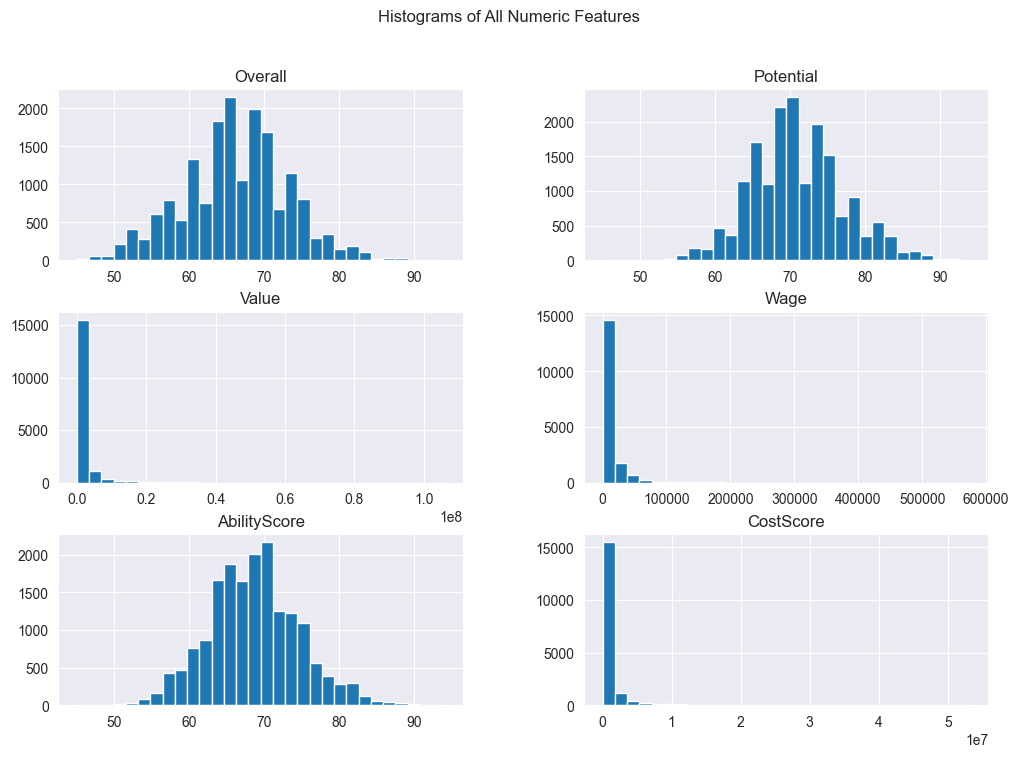

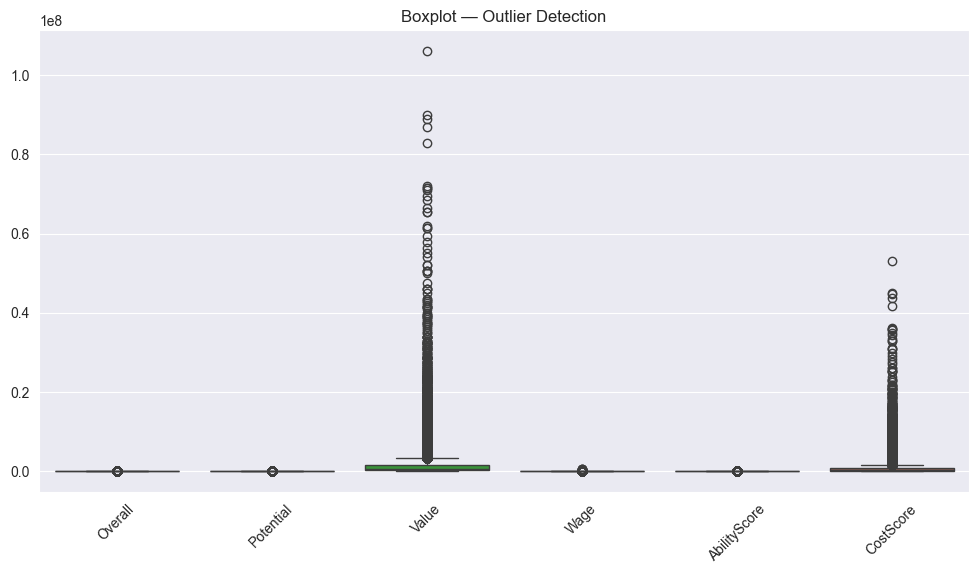

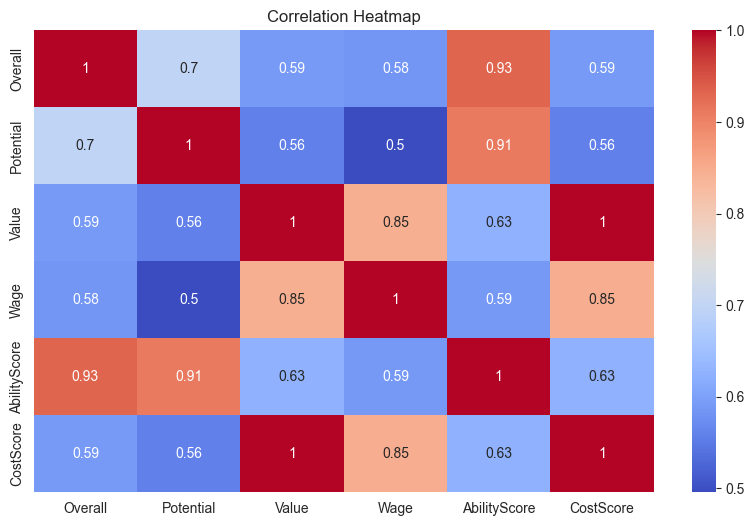

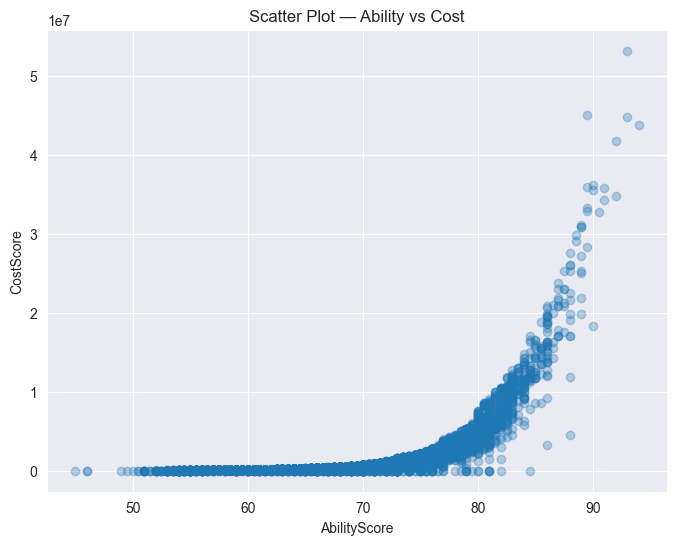

In [45]:
# ----------------------------------------------------
#  ALL REQUIRED VISUALIZATIONS
# ----------------------------------------------------
numerical = df[['Overall', 'Potential', 'Value', 'Wage', 'AbilityScore', 'CostScore']]

# --- Histograms ---
numerical.hist(figsize=(12, 8), bins=30)
plt.suptitle("Histograms of All Numeric Features")
plt.show()

# --- Boxplots (Outlier detection) ---
plt.figure(figsize=(12, 6))
sns.boxplot(data=numerical)
plt.title("Boxplot — Outlier Detection")
plt.xticks(rotation=45)
plt.show()

# --- Correlation Heatmap (MANDATORY) ---
plt.figure(figsize=(10, 6))
sns.heatmap(numerical.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# --- Scatter plot Ability vs Cost ---
plt.figure(figsize=(8, 6))
plt.scatter(df['AbilityScore'], df['CostScore'], alpha=0.3)
plt.title("Scatter Plot — Ability vs Cost")
plt.xlabel("AbilityScore")
plt.ylabel("CostScore")
plt.show()


In [46]:
# ----------------------------------------------------
# Step 4: Scaling before clustering
# ----------------------------------------------------
scaler = StandardScaler()
scaled_data = scaler.fit_transform(study_df[['AbilityScore', 'CostScore']])

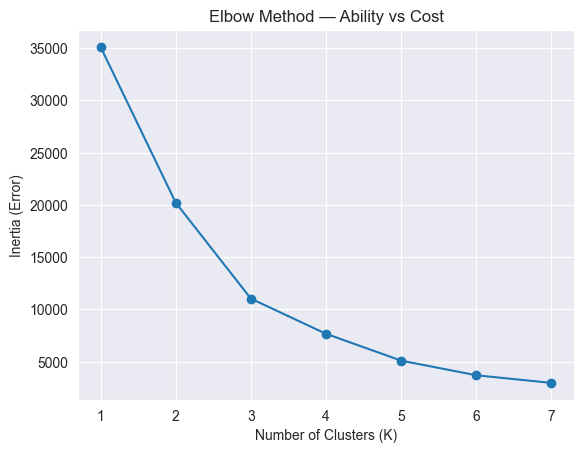

In [47]:
# ----------------------------------------------------
# Step 5: Determine optimal K using Elbow Method
# ----------------------------------------------------
errors = []
k_range = range(1, 8)

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    km.fit(scaled_data)
    errors.append(km.inertia_)

plt.plot(k_range, errors, marker='o')
plt.title("Elbow Method — Ability vs Cost")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia (Error)")
plt.show()

In [48]:
# ----------------------------------------------------
# Step 6: Apply KMeans (choose K=4 after elbow analysis)
# ----------------------------------------------------
kmeans = KMeans(n_clusters=4, random_state=42, n_init='auto')
study_df.loc[:, 'Cluster'] = kmeans.fit_predict(scaled_data)

In [49]:
# ----------------------------------------------------
# Step 7 (fixed): Assign REAL Matplotlib colors to clusters
# ----------------------------------------------------
matplotlib_colors = ['red', 'blue', 'green', 'yellow']

color_map = {
    0: matplotlib_colors[0],
    1: matplotlib_colors[1],
    2: matplotlib_colors[2],
    3: matplotlib_colors[3]
}

study_df.loc[:, "ClusterColor"] = study_df["Cluster"].map(color_map)

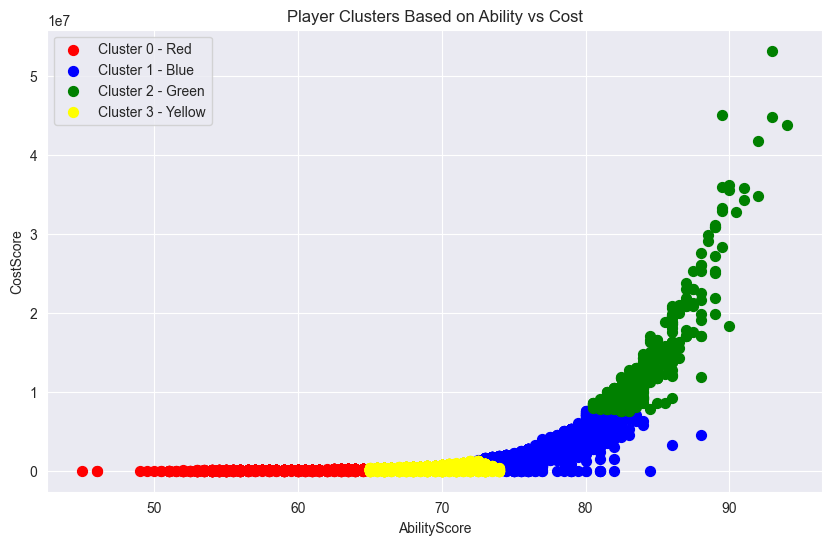

In [50]:
# ----------------------------------------------------
# Step 8 (fixed): Visualize clusters (correct legend colors)
# ----------------------------------------------------
plt.figure(figsize=(10, 6))

for cluster in sorted(study_df['Cluster'].unique()):
    cluster_data = study_df[study_df['Cluster'] == cluster]

    plt.scatter(
        cluster_data['AbilityScore'],
        cluster_data['CostScore'],
        s=50,
        color=color_map[cluster],  # FIXED
        label=f"Cluster {cluster} - {color_map[cluster].capitalize()}"
    )

plt.title("Player Clusters Based on Ability vs Cost")
plt.xlabel("AbilityScore")
plt.ylabel("CostScore")
plt.legend()
plt.show()

In [51]:
# ----------------------------------------------------
# Step 9: Analyze cluster meanings
# ----------------------------------------------------
print("\nCluster Means:")
print(study_df.groupby('Cluster')[['AbilityScore', 'CostScore']].mean())


Cluster Means:
         AbilityScore     CostScore
Cluster                            
0           61.152973  9.505639e+04
1           76.072398  2.236007e+06
2           84.045220  1.331517e+07
3           68.615750  3.944064e+05


In [52]:
# ----------------------------------------------------
# Step 10: Identify Hidden Gems (High ability + Low cost)
# ----------------------------------------------------
ability_threshold = study_df['AbilityScore'].quantile(0.60)
cost_threshold = study_df['CostScore'].quantile(0.40)

hidden_gems = study_df[
    (study_df['AbilityScore'] >= ability_threshold) &
    (study_df['CostScore'] <= cost_threshold)
]

hidden_gems = hidden_gems.sort_values("AbilityScore", ascending=False)

print("\nPep Guardiola scouting level:")
print(hidden_gems.head(20))


Hidden Gems (Top 20):
                  Name  AbilityScore  CostScore  Cluster ClusterColor
1021             Oscar          84.5        0.0        1         blue
77           A. Witsel          82.0        0.0        1         blue
40            Paulinho          81.0        0.0        1         blue
473         M. Almirón          81.0        0.0        1         blue
2            R. Cherki          81.0        0.0        1         blue
1084         D. Drogba          81.0        0.0        1         blue
260     Renato Augusto          80.0        0.0        1         blue
6004               Gil          80.0        0.0        1         blue
1713       J. Martínez          79.5        0.0        1         blue
2828       J. Valdivia          79.0        0.0        1         blue
1624         B. Yılmaz          79.0        0.0        1         blue
2308            Hilton          79.0    15000.0        1         blue
2385          Gervinho          79.0        0.0        1         bl

In [53]:
# ----------------------------------------------------
# FINAL STEP: Save complete dataset with cluster column
# ----------------------------------------------------

# Merge cluster numbers back to the original df
df.loc[:, "Cluster"] = study_df["Cluster"].values


# Export full dataset + cluster number
df.to_csv("fifa_full_with_clusters.csv", index=False)

# Export hidden gems file
hidden_gems.to_csv("hidden_gems_clean.csv", index=False)

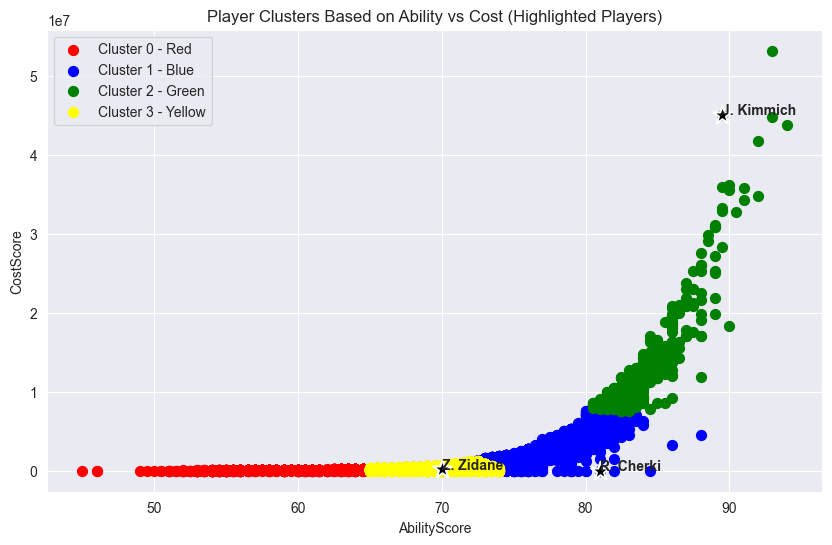

In [56]:
# ----------------------------------------------------
# PART 3: Visualize the three added points on the cluster plot
# ----------------------------------------------------

plt.figure(figsize=(10, 6))

# Plot all clusters first
for cluster in sorted(study_df['Cluster'].unique()):
    cluster_data = study_df[study_df['Cluster'] == cluster]

    plt.scatter(
        cluster_data['AbilityScore'],
        cluster_data['CostScore'],
        s=50,
        color=color_map[cluster],
        label=f"Cluster {cluster} - {color_map[cluster].capitalize()}"
    )

special_players = ["R. Cherki", "Z. Zidane", "J. Kimmich"]

for player in special_players:
    if player in study_df['Name'].values:
        p = study_df[study_df['Name'] == player].iloc[0]

        plt.scatter(
            p['AbilityScore'],
            p['CostScore'],
            color="black",
            s=200,
            marker="*",
            edgecolors="white",
            linewidth=1.5
        )

        plt.text(
            p['AbilityScore'] + 0.02,
            p['CostScore'] + 0.02,
            player,
            fontsize=10,
            fontweight='bold'
        )

plt.title("Player Clusters Based on Ability vs Cost (Highlighted Players)")
plt.xlabel("AbilityScore")
plt.ylabel("CostScore")
plt.legend()
plt.show()